# Team - NovaX # Model-X compettion



## 1. Data Loading and Filtering

To handle the large data set, here will not load the entire file into memory. Instead,try to use pandas to read only the specific non-medical columns that we want and will also simultaneously instruct pandas to recognize the special codes (-4, 8, 9)from the Data Dictionary as missing values(NaN) in nessasary columns
"

In [125]:
# main importings 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [126]:
columns_needed = [
    # Target
    'DEMENTED',
    
    # (A) A1: Demographics
    'NACCAGE', 'SEX', 'NACCNIHR', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED',

    # (B) b1: Physical & A5: Lifestyle do the person usually do have these
    'HEIGHT', 'WEIGHT','VISION', 'VISCORR', 'HEARING', 'HEARAID','TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER',
    'ALCOCCAS', 'ALCFREQ', 'ALCOHOL','ABUSOTHR','APNEA', 'RBD', 'INSOMN', 'OTHSLEEP',
    
    # (C) A5: Health History do the person has this in past
    'CVHATT',      # Heart attack
    'CVAFIB',      # Atrial fibrillation
    'CBSTROKE',    # Stroke
    'CBTIA',       # Mini-stroke
    'PD',          # Parkinson's
    'SEIZURES',
    'NACCTBI',     # Traumatic Brain Injury
    'DIABETES',
    'HYPERTEN',
    'HYPERCHO',    # High cholesterol
    'B12DEF','THYROID','ARTHRIT',
    
    # (D) A5: Psychiatric History - person suffer from these
    'PTSD', 'BIPOLAR', 'SCHIZ', 'DEP2YRS', 'DEPOTHR', 'ANXIETY', 'OCD', 'NPSYDEV',

    # (E) A3: Family History -  what family members had
    'NACCFAM', 'NACCMOM', 'NACCDAD',
    
    # (F) A4: Medication
    'ANYMEDS', 'NACCAMD' # Total number of meds
]

## 2.Data cleaning and Preprocessing
#### filter the data and add NAN values to clean


In [127]:
file_path = 'Dementia Prediction Dataset.csv'

try:
    df = pd.read_csv(file_path, usecols=columns_needed)
    print("Data Loaded Successfully!")

    general_codes = [-4, 8, 9, 99]
    columns_to_clean_general = [
        'SEX', 'NACCNIHR', 'PRIMLANG', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED',
        'VISION', 'VISCORR', 'HEARING', 'HEARAID', 'TOBAC30', 'TOBAC100', 'ALCOCCAS', 'ALCFREQ', 
        'ALCOHOL', 'ABUSOTHR', 'APNEA', 'RBD', 'INSOMN', 'OTHSLEEP',
        'CVHATT', 'CVAFIB', 'CBSTROKE', 'CBTIA', 'PD', 'SEIZURES', 'NACCTBI', 
        'DIABETES', 'HYPERTEN', 'HYPERCHO', 'B12DEF', 'THYROID', 'ARTHRIT',
        'PTSD', 'BIPOLAR', 'SCHIZ', 'DEP2YRS', 'DEPOTHR', 'ANXIETY', 'OCD', 'NPSYDEV',
        'NACCFAM', 'NACCMOM', 'NACCDAD', 'ANYMEDS'
    ]
    for col in columns_to_clean_general:
        if col in df.columns:
            df[col] = df[col].replace(general_codes, np.nan)

    # must treat these carefully to avoid deleting good data.    
    # 'EDUC': 9 is valid, but -4 and 99 are missing. so we will ensure about it more
    if 'EDUC' in df.columns:
        df['EDUC'] = df['EDUC'].replace([-4, 99], np.nan)
        
    # 'SMOKYRS': 9 is valid, but -4, 88, and 99 are missing.
    if 'SMOKYRS' in df.columns:
        df['SMOKYRS'] = df['SMOKYRS'].replace([-4, 88, 99], np.nan)
        
    # 'PACKSPER': 4 is valid, but -4, 8, and 9 are missing.
    if 'PACKSPER' in df.columns:
        df['PACKSPER'] = df['PACKSPER'].replace([-4, 8, 9], np.nan)
        
    # 'HEIGHT', 'WEIGHT', 'NACCAMD': 8, 9, 99 are "Unknown"
    # These are numerical, but 8 or 9 are not valid measures.
    if 'HEIGHT' in df.columns:
        df['HEIGHT'] = df['HEIGHT'].replace([-4, 8, 9, 99], np.nan)
    if 'WEIGHT' in df.columns:
        df['WEIGHT'] = df['WEIGHT'].replace([-4, 8, 9, 99], np.nan)
    if 'NACCAMD' in df.columns:
        df['NACCAMD'] = df['NACCAMD'].replace([-4, 8, 9, 99], np.nan)

    # 'NACCAGE' is assumed to be clean (no special codes there)

    #get teh summery
    df.info()
 
except FileNotFoundError:
    print(f"File not found.")
except ValueError as e:
    print(f" A problem occurred with the columns. {e}")


File not found.


### anlysing the `df.info`


Our df.info() output from above  we can see 195,196 total rows. While primary columns like NACCAGE and DEMENTED are 100% complete, we face a critical strategic challenge.

The Problem is that 90% Missing Data are here , A large group of our most promising features are like 90% empty.
Ex:-
ALCOCCAS (only 19k non-null),ARTHRIT (19k non-null),All Sleep Disorder features (APNEA, RBD, INSOMN, etc.)
,All Psychiatric History features (ANXIETY, PTSD, BIPOLAR, etc.)

Reason: As we know The Data Dictionary confirms these questions were only added in the UDS v3.0 form. All subjects from older v1.0 and v2.0 forms do not have this data.

So we have to do a stratergy
- A Two-Model Approach
Simply dropping these features (ANXIETY, ARTHRIT) is wasteful. The 19,000 rows that do contain this data may hold the most valuable predictive patterns.

Therefore, we will adopt a two-model strategy to find the best possible solution:

##### Model A (Base Model):

- Data: Use all 190000+ rows and then

- Features: We will drop the 90%-empty columns (ANXIETY, ARTHRIT, etc.). We will build a model using only the "common" features with high data availability (ex:- NACCAGE, EDUC, DIABETES, STROKE).

- Goal: A stable, generalized model trained on the full dataset.

##### Model B (Specialist Model):

- Data: Use a filtered subset of 19,000 rows where the special v3.0 data exists.

- Features: Use all features (common features + the powerful ANXIETY, ARTHRIT, OTHSLEEP features).

- Goal: A potentially more accurate, "expert" model, even if trained on less data.

We will build and evaluate both models and select the one with the best performance for our final submission.

So as Next Steps Building "Model A"
The next code cell will begin the process for Model A (Base Model). The plan is:

- Drop all columns with >90% missing data.

- Impute (Fill) missing tobacco data (where TOBAC100 = 0).

- Feature Engineer a new BMI column from HEIGHT and WEIGHT.

- Analyze the balance of our target variable, DEMENTED.


In [128]:
df.head(5)

,SEX,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,HANDED,NACCFAM,NACCMOM,...,HEIGHT,WEIGHT,VISION,VISCORR,HEARING,HEARAID,DEMENTED,NACCNIHR,NACCAGE,NACCAMD
0,1,1.0,16.0,1.0,4.0,1.0,1.0,2.0,1.0,0.0,...,71.0,232.0,0.0,1.0,1.0,0.0,0,1.0,70,13.0
1,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,...,71.0,220.0,0.0,1.0,1.0,0.0,0,1.0,71,12.0
2,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,...,72.0,175.0,NaN,NaN,1.0,0.0,0,1.0,66,4.0
3,2,2.0,16.0,1.0,2.0,2.0,1.0,2.0,NaN,NaN,...,88.8,888.0,1.0,0.0,1.0,0.0,1,1.0,63,3.0
4,1,1.0,12.0,3.0,1.0,1.0,1.0,2.0,NaN,0.0,...,65.0,114.0,0.0,1.0,0.0,0.0,0,1.0,77,1.0


In [129]:
# drop all the columns with 90% missing dsata
#We set our threshold to 30,000 based on the cliff we saw in the df.info()

min_data_threshold = 30000

# findingg the columns do not meet the threshold
columns_to_drop = df.columns[df.count() < min_data_threshold]

columns_to_drop = [col for col in columns_to_drop if col != 'DEMENTED']

In [130]:
columns_to_drop

['ALCOCCAS',
 'ALCFREQ',
 'ARTHRIT',
 'APNEA',
 'RBD',
 'INSOMN',
 'OTHSLEEP',
 'PTSD',
 'BIPOLAR',
 'SCHIZ',
 'ANXIETY',
 'OCD',
 'NPSYDEV']

### Later we will use these special feature data tooo in model B - specialized model



In [131]:
df_base_model = df.drop(columns=columns_to_drop)
df_base_model

,SEX,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,HANDED,NACCFAM,NACCMOM,...,HEIGHT,WEIGHT,VISION,VISCORR,HEARING,HEARAID,DEMENTED,NACCNIHR,NACCAGE,NACCAMD
0,1,1.0,16.0,1.0,4.0,1.0,1.0,2.0,1.0,0.0,...,71.0,232.0,0.0,1.0,1.0,0.0,0,1.0,70,13.0
1,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,...,71.0,220.0,0.0,1.0,1.0,0.0,0,1.0,71,12.0
2,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,...,72.0,175.0,NaN,NaN,1.0,0.0,0,1.0,66,4.0
3,2,2.0,16.0,1.0,2.0,2.0,1.0,2.0,NaN,NaN,...,88.8,888.0,1.0,0.0,1.0,0.0,1,1.0,63,3.0
4,1,1.0,12.0,3.0,1.0,1.0,1.0,2.0,NaN,0.0,...,65.0,114.0,0.0,1.0,0.0,0.0,0,1.0,77,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195191,2,1.0,13.0,4.0,4.0,2.0,NaN,2.0,NaN,0.0,...,88.8,888.0,0.0,1.0,0.0,1.0,1,2.0,72,10.0
195192,1,1.0,13.0,2.0,1.0,1.0,1.0,2.0,NaN,0.0,...,71.7,196.0,0.0,1.0,0.0,1.0,0,1.0,87,7.0
195193,1,1.0,13.0,2.0,1.0,3.0,2.0,2.0,NaN,0.0,...,72.0,200.0,0.0,1.0,0.0,0.0,1,1.0,89,5.0
195194,1,1.0,13.0,2.0,1.0,3.0,2.0,2.0,NaN,0.0,...,73.0,193.0,0.0,1.0,0.0,1.0,1,1.0,89,10.0


In [132]:
df_base_model.shape

(195196, 42)

##### try to remeove any duplicaets in this

In [133]:
num_duplicates = df_base_model.duplicated().sum()
num_duplicates

np.int64(933)

In [ ]:
# there are duplicates
f_base_model=df_base_model.drop_duplicates()
df_base_model.shape

(195196, 42)

##### Impute Missing Tobacco Data

As we discussed, we cannot blindly fill all NaNs in SMOKYRS (Years Smoked) with 0. There are two types of NaNs:

Logical NaNs: TOBAC100 = 0 (No), so SMOKYRS is skipped. These should be 0.

True Missing NaNs: TOBAC100 = 1 (Yes), but the person forgot to answer SMOKYRS. These should not be 0.

we will only fill the "Logical NaNs" (Case 1). The "True Missing NaNs" (Case 2) will be handled later in our general imputation step (use with the median or most appropriate value).

In [95]:
# We assume if it's missing, they are likely a non-smoker (0).
if 'TOBAC100' in df_base_model.columns:
    df_base_model['TOBAC100'] = df_base_model['TOBAC100'].fillna(0)

In [96]:
# Now, apply the conditional logic
# Condition:- Where TOBAC100 is 0 as NO
condition_non_smoker = (df_base_model['TOBAC100'] == 0)
tobacco_cols_to_fill = ['SMOKYRS', 'PACKSPER', 'TOBAC30']

for col in tobacco_cols_to_fill:
    if col in df_base_model.columns:
        # We fill NaNs with 0 ONLY for the rows that meet the condition
        df_base_model.loc[condition_non_smoker, col] = df_base_model.loc[condition_non_smoker, col].fillna(0)


In [97]:
df_base_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195196 entries, 0 to 195195
Data columns (total 42 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEX       195196 non-null  int64  
 1   PRIMLANG  192164 non-null  float64
 2   EDUC      194222 non-null  float64
 3   MARISTAT  194300 non-null  float64
 4   NACCLIVS  194872 non-null  float64
 5   INDEPEND  194599 non-null  float64
 6   RESIDENC  192318 non-null  float64
 7   HANDED    194164 non-null  float64
 8   NACCFAM   177430 non-null  float64
 9   NACCMOM   189004 non-null  float64
 10  NACCDAD   186937 non-null  float64
 11  ANYMEDS   192457 non-null  float64
 12  TOBAC30   195126 non-null  float64
 13  TOBAC100  195196 non-null  float64
 14  SMOKYRS   192423 non-null  float64
 15  PACKSPER  192544 non-null  float64
 16  CVHATT    123136 non-null  float64
 17  CVAFIB    122935 non-null  float64
 18  CBSTROKE  123065 non-null  float64
 19  CBTIA     122374 non-null  float64
 20  PD  

In [98]:
df_base_model.isnull().sum()

SEX             0
PRIMLANG     3032
EDUC          974
MARISTAT      896
NACCLIVS      324
INDEPEND      597
RESIDENC     2878
HANDED       1032
NACCFAM     17766
NACCMOM      6192
NACCDAD      8259
ANYMEDS      2739
TOBAC30        70
TOBAC100        0
SMOKYRS      2773
PACKSPER     2652
CVHATT      72060
CVAFIB      72261
CBSTROKE    72131
CBTIA       72822
PD          72052
SEIZURES    72202
NACCTBI     72904
DIABETES    72087
HYPERTEN    72089
HYPERCHO    72800
B12DEF      73956
THYROID     72569
ALCOHOL     72076
ABUSOTHR    72021
DEP2YRS     72802
DEPOTHR     73391
HEIGHT      26396
WEIGHT      26581
VISION      28864
VISCORR     28150
HEARING     28725
HEARAID     28061
DEMENTED        0
NACCNIHR     2559
NACCAGE         0
NACCAMD     31920
dtype: int64

#### use Feature engineering technique to shortage the columns furthermrore
use BMI instead of height,weight

We will:
- Calculate BMI using the formula: BMI = Weight (kg) / Height (m)^2
- Convert our units (inches to meters, lbs to kg).
- Create the new BMI column.Drop the original HEIGHT and WEIGHT columns to simplify our dataset

In [99]:
height = df_base_model['HEIGHT']* 0.0254  # 1 inch = 0.0254 m
weight = df_base_model['WEIGHT']* 0.453592 # 1 lb = 0.453592 kg

df_base_model['BMI'] = weight/(height**2)
df_base_model['BMI'] = df_base_model['BMI'].replace([np.inf,-np.inf],np.nan)

In [100]:
df_base_model['BMI']

0         32.357074
1         30.683432
2         23.734004
3         79.174438
4         18.970383
            ...    
195191    79.174438
195192    26.804994
195193    27.124576
195194    25.462998
195195    26.660474
Name: BMI, Length: 195196, dtype: float64

In [101]:
df_base_model = df_base_model.drop(columns=['HEIGHT','WEIGHT'])

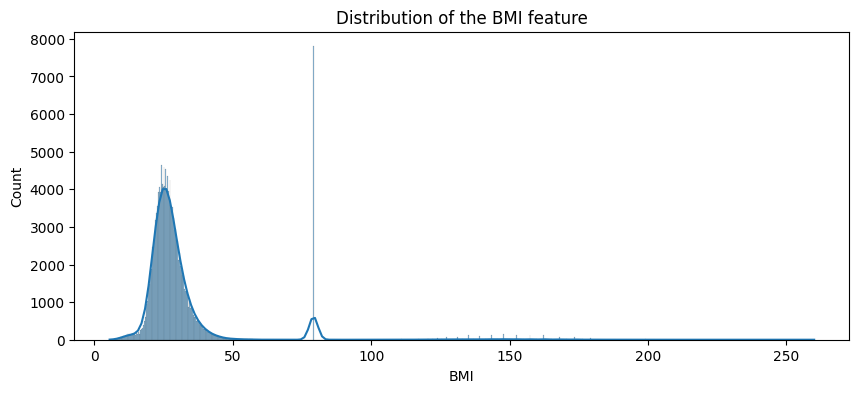

In [102]:
# look at the distribution of the BMI feature
plt.figure(figsize=(10,4))
sns.histplot(df_base_model['BMI'].dropna(),kde=True)
plt.title('Distribution of the BMI feature')
plt.show()

We will:

- Plot a boxplot of the original (dirty) BMI data to visually confirm the data entry errors.

- Define a plausible BMI range (15 to 55) and set all values outside it to NaN.

- Plot a second boxplot of the cleaned BMI data to confirm the outliers were successfully removed.

<Axes: xlabel='BMI'>

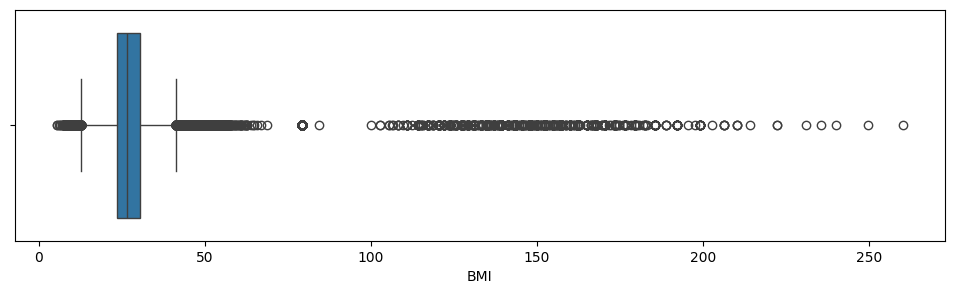

In [103]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_base_model['BMI'])
# before cleaning

In [104]:
# define our plasusible BMI range to 15 - 55 and will clean others
min_bmi = 15
max_bmi = 55


df_base_model.loc[(df_base_model['BMI']<min_bmi) | (df_base_model['BMI']>max_bmi), 'BMI'] = np.nan

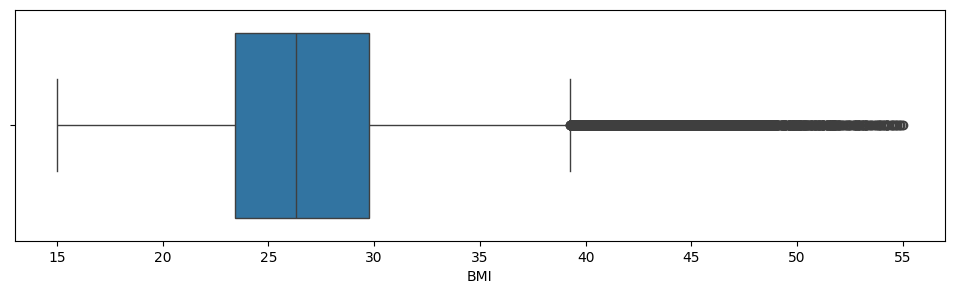

In [105]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_base_model['BMI'].dropna())
plt.show()

boxplots for each of our main numerical features to quickly check their quality

In [106]:
numerical_features_to_check = ['NACCAGE', 'EDUC', 'SMOKYRS', 'NACCAMD']

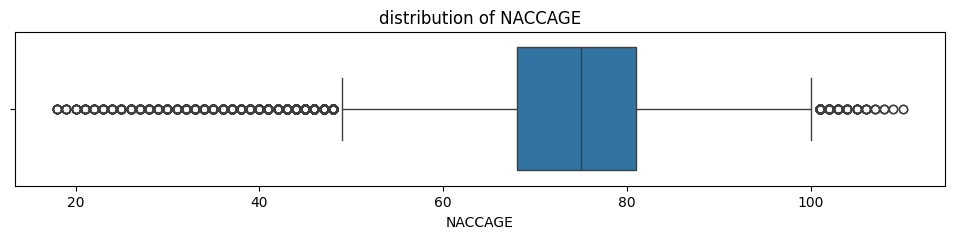

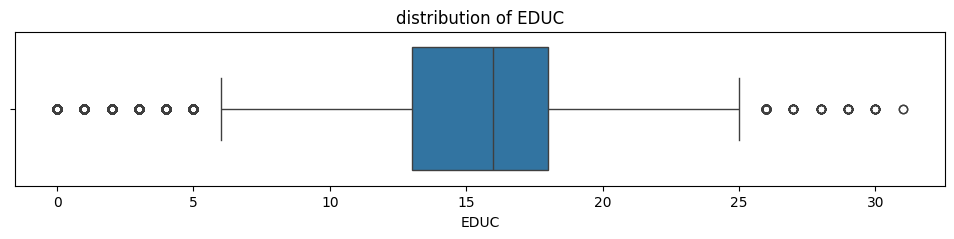

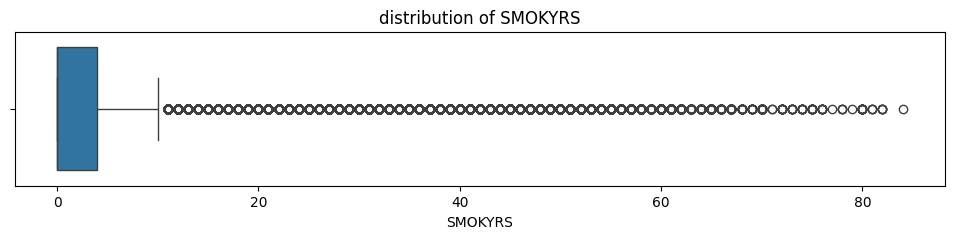

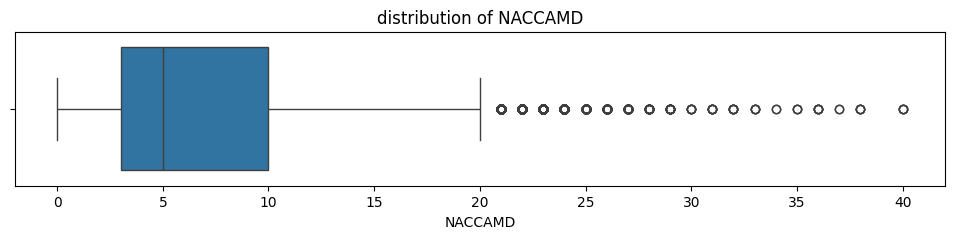

In [107]:
for col in numerical_features_to_check:
    if col in df_base_model.columns:
        plt.figure(figsize=(12,2))
        sns.boxplot(x=df_base_model[col].dropna())
        plt.title(f'distribution of {col}')
        plt.xlabel(col)
        plt.show()

lets find is they any not valid in numerical

In [114]:
# allowablew range 18-120 in there
count_outliers1 = df_base_model['NACCAGE'][df_base_model['NACCAGE']>120].count()
# df_base_model.loc[df_base_model['NACCAGE']>100, 'NACCAGE'] = np.nan 
count_outliers1

np.int64(0)

In [109]:
count_outliers2 = df_base_model['EDUC'][df_base_model['EDUC']>36].count()
count_outliers2


np.int64(0)

In [113]:

df_base_model['PACKSPER'] = df_base_model['PACKSPER'].replace([-4, 8, 9], np.nan)
    
#logical errors (any value > 5)
count_outliers = df_base_model['PACKSPER'][df_base_model['PACKSPER'] > 5].count()
count_outliers

np.int64(0)

now we look at the target varible - DEMENTED to find impbalancing

In [115]:
df_base_model['DEMENTED']

0         0
1         0
2         0
3         1
4         0
         ..
195191    1
195192    0
195193    1
195194    1
195195    0
Name: DEMENTED, Length: 195196, dtype: int64

In [119]:
target_counts = df_base_model['DEMENTED'].value_counts()
target_counts

DEMENTED
0    137606
1     57590
Name: count, dtype: int64

In [121]:
df_base_model['DEMENTED'].value_counts(normalize=True) * 100

DEMENTED
0    70.496322
1    29.503678
Name: proportion, dtype: float64

can be seen some unbalanced here

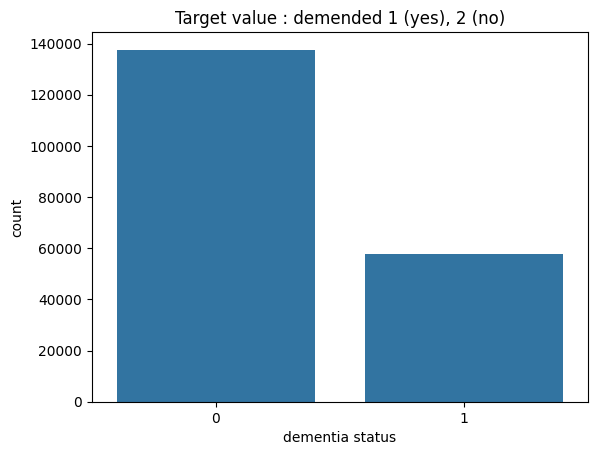

In [120]:
sns.countplot(x='DEMENTED', data = df_base_model)
plt.title('Target value : demended 1 (yes), 2 (no)')
plt.ylabel('count')
plt.xlabel('dementia status')
plt.xticks([0,1])
plt.show()

The 70/30 split is "moderately imbalanced". If we train on it, the model will be biased.so we will do Oversampling teqnique like SMOTE is to perfect solution to get to 50/50.But, before it follow one very important thing to prevent data leakage:First, we must clean all NaN values and then we will split our data into a train set and a test set.after will apply SMOTE only to the train set.
